In [1]:
# Standard library imports
from pathlib import Path
import os
import sys
import math
import itertools
from typing import List, Union, Sequence


# Third-party library imports
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from numpy import ndarray
from tqdm import tqdm
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
from torch_geometric.data import Data, Batch
from torch_geometric.nn import ChebConv
from torch_geometric.nn.conv import GeneralConv


# Project-specific import
from Utils_GAN.classes import DynamicGraphTemporalSignal, GConvGRU, BoidDatasetLoader,RecurrentGCN
from Utils_GAN.classes import Encoder,Decoder,GraphSeqGenerator
from Utils_GAN.classes import GraphSeqDiscriminator,GraphSeqGenerator


from Utils_GAN.subfunctions import temporal_signal_split, train,plot_predictions,test,create_video_from_images
from Utils_GAN.subfunctions import train_generator,test_generator,test_generator_plot

### For Now: Grabbing Parts of Pytorch Geometric Temporal As Having Difficulty Setting Up The Environment For It

## Set Up BoidDatasetLoader To Load Entire Dataset
Following Example of EnglandCovidDatasetLoader from Pytorch Geometric Temporal

In [2]:
class BoidDatasetLoader(object):
    """
    The BoidDatasetLoader class is designed to load and process the Boid Dataset.
    It reads data from CSV files, processes it, and prepares it for further analysis or modeling. The class performs the
    following key functions:

    1. Initialization (__init__ method):
       - Calls the _read_data method to load and preprocess the data.

    2. Data Reading and Preprocessing (_read_data method):
       - Reads simulation data from 'simulation.csv' and 'simulation_edges.csv'.
       - Drops the 'Simulation' column from both dataframes.
       - Renames columns to standardize the naming convention (e.g., 'Boids' to 'BoidID', 'Boid_i' to 'BoidID_i').
       - Stores the cleaned dataframes in the _dataset attribute.
       - Calls the _process_dataset method to further process the data and extract features, edges, and edge weights.

    3. Dataset Processing (_process_dataset method):
       - Groups the simulation data by 'Timestep'.
       - Initializes lists to store edge indices, node features, and distances.
       - Iterates over each timestep to extract relevant data for that timestep.
       - Converts the dataframes to NumPy arrays for efficient computation.
       - Creates a dictionary to map BoidID to coordinates.
       - Uses vectorized operations to calculate distances between boids with edges.

    4. Getting Features and Edge Weights (_get_edge_weights() and _get_features() methods):
        - Normalized features and _edge_weights using min-max normalization
        - Attributes are now normalized when called and returned

    5. Getting Target (_get_target() method):
        - If t is the current index of our dataset, then t+1 is the target
        - Contains the node features of the graph at t+1
        - Will probably not used this as wouldnt work entirely for more than 1 timestep prediction

    Attributes:
        _dataset: A tuple containing the cleaned simulation data and edge data.
        features: Node features extracted from the simulation data.
        _edges: Edge indices representing connections between boids.
        _edge_weights: Weights of the edges, which could represent distances or other metrics.

    Methods:
        __init__(): Initializes the class and reads the data.
        _read_data(): Reads and preprocesses the data from CSV files.
        _process_dataset(sim_df, sim_edges_df): Processes the dataset to extract features, edges, and edge weights.
    """
    def __init__(self, dim_of_sim=(1000, 1000)):
        self._read_data()
        self.dim_of_sim = dim_of_sim 

    def _read_data(self):
        path_to_sim = '../data/simulation.csv'
        path_to_sim_edges = '../data/simulation_edges.csv'
        sim_df = pd.read_csv(path_to_sim)
        sim_edges_df = pd.read_csv(path_to_sim_edges)

        sim_df.drop(columns='Simulation', inplace=True)
        sim_df.rename(columns={'Boids':'BoidID'}, inplace=True)

        sim_edges_df.drop(columns='Simulation', inplace=True)
        sim_edges_df.rename(columns={'Boid_i':'BoidID_i', 'Boid_j':'BoidID_j'}, inplace=True)
        
        self._dataset = (sim_df, sim_edges_df)
        self.features, self._edges, self._edge_weights = self._process_dataset(self._dataset[0], self._dataset[1])

    def _process_dataset(self, sim_df, sim_edges_df):
        # Group the dataframes by 'Timestep'
        sim_grouped = sim_df.groupby('Timestep')
        edges_grouped = sim_edges_df.groupby('Timestep')
        
        # Initialize lists to store edge indices and node features
        edge_indices = []
        node_features = []
        
        distances = []

        # Iterate over each group
        for timestep, _ in sim_grouped:
            # Extract relevant columns for the current timestep
            timestep_df = sim_grouped.get_group(timestep)[['x', 'y', 'dx', 'dy', 'BoidID']]
            timestep_edges_df = edges_grouped.get_group(timestep)[['BoidID_i', 'BoidID_j']]
            
            # Convert dataframes to numpy arrays
            node_array = timestep_df[['x', 'y', 'dx', 'dy']].to_numpy()
            edge_array = timestep_edges_df.to_numpy().T

            # Create a dictionary to map BoidID to coordinates
            boid_coords = {boid_id: coords for boid_id, coords in zip(timestep_df['BoidID'], timestep_df[['x', 'y']].values)}
            
            # Get coordinates for boids involved in edges
            boid_i_coords = np.array([boid_coords[boidID_i] for boidID_i in edge_array[0]])
            boid_j_coords = np.array([boid_coords[boidID_j] for boidID_j in edge_array[1]])
            
            # Calculate distances using vectorized operations
            timestep_distances = np.linalg.norm(boid_i_coords - boid_j_coords, axis=1)
            
            distances.append(timestep_distances)

            # Append the numpy arrays to the respective lists
            edge_indices.append(edge_array)
            node_features.append(node_array)

        # Return the lists of edge indices and node features
        return node_features, edge_indices, distances

    def _compute_feature_min_max(self, feature_list):
        """
        Compute the minimum and maximum of features across all node features.

        Parameters:
        all_node_features (list of np.ndarray): List of numpy arrays containing node features.

        Returns:
        tuple: A tuple containing two numpy arrays: (final_min, final_max).
        """
        if not feature_list:
            raise ValueError("The input list 'all_node_features' is empty.")
        
        # Initialize final_min and final_max with appropriate dimensions
        if len(feature_list[0].shape) == 0:
            raise ValueError('The input list is missing node features') 
        
        if len(feature_list[0].shape) == 1:
            feature_dim = 1
            axis_val = None
            final_min = float('inf')
            final_max = float('-inf')
        else:
            feature_dim = feature_list[0].shape[1]
            axis_val = 0
            final_min = np.array([float('inf')] * feature_dim)
            final_max = np.array([float('-inf')] * feature_dim)
        
        # Iterate through all node features to compute final_min and final_max
        for features in feature_list:
            curr_max = np.max(features, axis=axis_val)
            curr_min = np.min(features, axis=axis_val)
            final_max = np.max(np.array([final_max, curr_max]), axis=0)
            final_min = np.min(np.array([final_min, curr_min]), axis=0)
        
        return final_min, final_max
    
    def _minmax_scale(self, feature_list, final_min, final_max):
        normalized = []
        for i in range(len(feature_list)):
            X = feature_list[i]
            X_std = (X - final_min) / (final_max - final_min)
            normalized.append(X_std)
        return normalized

    def undo_minmax_scale(self, normalized_feature_list, final_min, final_max):
        unnormalized = []
        for i in range(len(normalized_feature_list)):
            X_std = normalized_feature_list[i]
            X_scaled = X_std * (final_max - final_min) + final_min
            unnormalized.append(X_scaled)
        return unnormalized
    

    def _get_edge_weights(self):
        self.min_edge_weight, self.max_edge_weight = self._compute_feature_min_max(self._edge_weights)
        self._edge_weights = self._minmax_scale(self._edge_weights, self.min_edge_weight, self.max_edge_weight)

    def _get_features(self):
        self.min_features, self.max_features = self._compute_feature_min_max(self.features)
        self.features = self._minmax_scale(self.features, self.min_features, self.max_features)
    def _get_targets(self):
        self.targets = [self.features[i] for i in range(1, len(self.features))]


    def get_dataset(self) -> DynamicGraphTemporalSignal:

        self._get_edge_weights()
        self._get_features()
        self._get_targets()
        dataset = DynamicGraphTemporalSignal(
            self._edges[:len(self.features)-1], 
            self._edge_weights[:len(self.features)-1], 
            self.features[:len(self.features)-1], 
            self.targets
        )
        return dataset

In [3]:
loader = BoidDatasetLoader()
dataset = loader.get_dataset()
dataset.snapshot_count

9999

# Split Dataset Into Training and Testing

In [4]:
# Source: https://github.com/benedekrozemberczki/pytorch_geometric_temporal/blob/master/torch_geometric_temporal/signal/train_test_split.py

def temporal_signal_split(data_iterator, train_ratio=0.8):
    train_snapshots = int(data_iterator.snapshot_count * train_ratio)
    train_iterator = data_iterator[0:train_snapshots]
    test_iterator = data_iterator[train_snapshots:]
    return train_iterator, test_iterator

In [5]:
train_dataset, test_dataset = temporal_signal_split(dataset)

train_dataset.snapshot_count, test_dataset.snapshot_count

(7999, 2000)

In [6]:
OBS_LENGTH = 8
PRED_LENGTH = 8 
BATCH_SIZE = 128
NUM_BOIDS = 100
VISUAL_RANGE = 75
K = 5

In [7]:
def make_batch(list_of_sequences, seq_length):
    batch_dataset = []
    # Look at the first item in the sequence, and then second and so on
    for t in range(seq_length):
        batch_list = []
        # Iterate through list_of_sequences and add the the t-th item from each of them to the batch_list
        for i in range(len(list_of_sequences)):
            batch_list.append(list_of_sequences[i][t])
        # Create a Batch Object from batch_list and add that to batch_dataset
        batch_dataset.append(Batch.from_data_list(batch_list))
    return batch_dataset

def dataLoader(dataset, window=8, delay=0, horizon=1, stride=1, batch_size=32):
    sample_span = window + delay + horizon
    total_timesteps = dataset.snapshot_count
    # First get list of observed sequences and their corresponding target sequences
    obs_seq_list = []
    target_seq_list = []
    for start in tqdm(range(0, total_timesteps - sample_span + 1, stride), desc='Getting Observation and Target Sequences'):
        obs_seq = dataset[start:start + window]
        obs_seq_list.append(obs_seq)
        target_seq = dataset[start + window + delay: start + window + delay + horizon]
        target_seq_list.append(target_seq)
    # Second need to break up the list into bactches of size BATCH_SIZE
    batch_list = []
    for i in tqdm(range(0, len(obs_seq_list), batch_size), desc="Making Fresh Batches"):
        # Get the start and end index for the batch
        start, end = i, min(i+batch_size, len(obs_seq_list)) # Doing min here in case I don't have enough in my list to make a complete batch
        # Grab a sample of both list to create a batch
        sample_obs_seq_list = obs_seq_list[start:end]
        sample_target_seq_list = target_seq_list[start:end]

        # Calling helper function make_batch to create a batch from a list of sequences
        curr_obs_batch = make_batch(sample_obs_seq_list, window)
        curr_target_batch = make_batch(sample_target_seq_list, horizon)
        batch_list.append((curr_obs_batch, curr_target_batch))

    return batch_list

train_batches = dataLoader(train_dataset, window=OBS_LENGTH, horizon=PRED_LENGTH, batch_size=BATCH_SIZE)
len(train_batches)

Making Fresh Batches: 100%|██████████| 63/63 [00:07<00:00,  7.99it/s]


63

## Training

## GAN [Generator: (Encoder, Decoder)] [Discriminator: (Encoder)]

In [8]:
def get_noise(shape, noise_type):
    if noise_type == 'gaussian':
        return torch.randn(*shape)
    elif noise_type == 'uniform':
        return torch.rand(*shape).sub_(0.5).mul_(2.0)
    raise ValueError('Unrecognized noise type "%s"' % noise_type)

class GraphSeqGenerator(torch.nn.Module):
    def __init__(self, node_feat_dim, enc_hidden_dim, enc_latent_dim, dec_hidden_dim, obs_len, target_len, num_boids, batch_size, min_max_x, min_max_y, min_max_edge_weight, visual_range, device):
        super(GraphSeqGenerator, self).__init__()
        self.encoder = Encoder(node_feat_dim, enc_hidden_dim, enc_latent_dim-1)
        self.decoder = Decoder(enc_latent_dim, dec_hidden_dim, node_feat_dim)
        self.target_len = target_len
        self.obs_len = obs_len
        self.num_boids = num_boids
        self.batch_size = batch_size
        self.node_feat_dim = node_feat_dim
        self.min_x, self.max_x = min_max_x
        self.min_y, self.max_y = min_max_y
        self.min_edge_weight, self.max_edge_weight = min_max_edge_weight
        self.visual_range = visual_range
        self.device = device

    def _compute_edge_index_and_weight(self, y_hat_batch):
        # Grab x and y features
        y_hat_x_batch = y_hat_batch[:, 0] 
        y_hat_y_batch = y_hat_batch[:, 1]

        # Undo normalization
        y_hat_x_batch = y_hat_x_batch * (self.max_x - self.min_x) + self.min_x
        y_hat_y_batch = y_hat_y_batch * (self.max_y - self.min_y) + self.min_y

        coords = torch.stack((y_hat_x_batch, y_hat_y_batch), dim=1)
        
        coords = torch.reshape(coords, (-1, self.num_boids, 2)) # A single dimension may be -1, in which case it’s inferred from the remaining dimensions and the number of elements in input
        distances = torch.cdist(coords, coords, p=2)

        edge_index_list = []
        edge_weight_list = []
        for i in range(distances.shape[0]):
            curr_dist = distances[i]

            indices = torch.where((curr_dist < self.visual_range) & (curr_dist > 0))
            edge_index = torch.vstack((indices[0], indices[1]))
            edge_weight = curr_dist[indices]

            edge_index_list.append(edge_index)
            edge_weight_list.append(edge_weight)

        return edge_index_list, edge_weight_list
    
    def _convertToDataBatch(self, y_hat_batch, y_hat_edge_index_batch, y_hat_edge_attr_batch):
        y_hat_batch = torch.reshape(y_hat_batch, (-1, self.num_boids, self.node_feat_dim))

        data_list = [Data(x=y_hat_batch[i], edge_index=y_hat_edge_index_batch[i], edge_attr=y_hat_edge_attr_batch[i]) for i in range(y_hat_batch.shape[0])]
        return Batch.from_data_list(data_list)
        
    def _add_noise(self, input, user_noise='gaussian'):
        noise_vector = get_noise(shape=(input.shape[0], 1), noise_type=user_noise).to(self.device)
        return torch.cat((input, noise_vector), dim=1)

    def forward(self, obs_seq_batch, h_enc, h_dec):
        # Warmup Section
        for i in range(self.obs_len):
            snapshot_batch = obs_seq_batch[i]

            z_batch, h_enc_0 = self.encoder(snapshot_batch.x, snapshot_batch.edge_index, snapshot_batch.edge_attr, h_enc)
            z_noisy_batch = self._add_noise(z_batch, user_noise='gaussian')
            y_hat_batch, h_dec_0 = self.decoder(z_noisy_batch, snapshot_batch.edge_index, snapshot_batch.edge_attr, h_dec)

            h_enc = h_enc_0
            h_dec = h_dec_0

        y_hat_edge_index_batch, y_hat_edge_attr_batch = self._compute_edge_index_and_weight(y_hat_batch)

        pred_snapshot_batch_list = []

        pred_snapshot_batch = self._convertToDataBatch(y_hat_batch, y_hat_edge_index_batch, y_hat_edge_attr_batch)

        pred_snapshot_batch_list.append(pred_snapshot_batch)
        
        
        # Prediction Section
        for _ in range(self.target_len-1):
            y_hat_batch = pred_snapshot_batch.x
            y_hat_edge_index_batch = pred_snapshot_batch.edge_index
            y_hat_edge_attr_batch = pred_snapshot_batch.edge_attr

            z_batch, h_enc_0 = self.encoder(y_hat_batch, y_hat_edge_index_batch, y_hat_edge_attr_batch, h_enc)
            z_noisy_batch = self._add_noise(z_batch, user_noise='gaussian')
            y_hat_batch, h_dec_0 = self.decoder(z_noisy_batch, y_hat_edge_index_batch, y_hat_edge_attr_batch, h_dec)

            y_hat_edge_index_batch, y_hat_edge_attr_batch = self._compute_edge_index_and_weight(y_hat_batch)

            pred_snapshot_batch = self._convertToDataBatch(y_hat_batch, y_hat_edge_index_batch, y_hat_edge_attr_batch)
            pred_snapshot_batch_list.append(pred_snapshot_batch)

        return pred_snapshot_batch_list

In [9]:
class GraphSeqDiscriminator(torch.nn.Module):
    def __init__(self, node_feat_dim, enc_hidden_dim, enc_latent_dim, obs_len, target_len, num_boids):
        super(GraphSeqDiscriminator, self).__init__()
        self.encoder = Encoder(node_feat_dim, enc_hidden_dim, enc_latent_dim)
        self.linear = torch.nn.Linear(enc_latent_dim * num_boids, 1)
        self.obs_len = obs_len
        self.target_len = target_len
        self.num_boids = num_boids
    
    def forward(self, batch_obs_seq, h_enc):
        for i in range(self.target_len):
            snapshot_batch = batch_obs_seq[i]
            z_batch, h_enc_0 = self.encoder(snapshot_batch.x, snapshot_batch.edge_index, snapshot_batch.edge_attr, h_enc)
            h_enc = h_enc_0
        
        z_batch = F.leaky_relu(z_batch)
        # Reshaping z_batch from dim (num_boids*batch_size, num_latent) to dim (batch_size, enc_latent_dim*num_boids)
        z_batch = torch.reshape(z_batch, (-1, self.num_boids*z_batch.shape[1])) 
        out_batch = self.linear(z_batch)
        out_batch = torch.sigmoid(out_batch)

        return out_batch, h_enc_0

In [10]:
# Range btw [0.7, 1.0]
def smooth_positive_labels(y, device):
    return torch.sub(y, 0.3) + torch.mul(torch.rand(size=y.size(), device=device), 0.3)
# Range btw [0, 0.3]        
def smooth_negative_labels(y, device):                                 
    return y + torch.mul(torch.rand(size=y.size(), device=device), 0.3)
def train_gan(train_batches, num_epochs, generator, discriminator, criterion, optimizer_gen, optimizer_disc, batch_size, device, k=1):
    """
    Trains the given model using the provided training data.

    Args:
        train_data (Dataset): The dataset containing the training data.
        num_epochs (int): The number of epochs to train the model.
        model (nn.Module): The model to be trained.
        optimizer (Optimizer): The optimizer used for training the model.
        window (int, optional): The size of the input sequence window. Defaults to 8.
        delay (int, optional): The delay between the input sequence and the target sequence. Defaults to 0.
        horizon (int, optional): The prediction horizon. Defaults to 1.
        stride (int, optional): The stride for iterating over the training data. Defaults to 1.

    Returns:
        None
    """
    

    generator.train()
    discriminator.train()
    
    losses_over_iterations = {
        'Generator': [],
        'Discriminator': [],
        'Dx': [],
        'D_G_z1': [],
        'D_G_z2': [],
        'Variety': [],
    }

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        for i, batch in enumerate(tqdm(train_batches, desc='Training')):
            obs_seq_batch = batch[0]
            target_seq_batch = batch[1]

            obs_seq_batch = [obs_batch.to(device) for obs_batch in obs_seq_batch]
            target_seq_batch = [target_batch.to(device) for target_batch in target_seq_batch]

            y_hat_seq_batch = generator(obs_seq_batch, None, None)

            # Discriminator Step
            discriminator.zero_grad()

            output_real_batch, _ = discriminator(target_seq_batch, None)
            smooth_pos_labels = smooth_positive_labels(torch.ones(min(batch_size, output_real_batch.shape[0]), device=device), device=device)
            err_disc_real_batch = criterion(output_real_batch.squeeze(), smooth_pos_labels)
            err_disc_real_batch.backward()
            D_x = output_real_batch.mean().item()

            # Need to detach the y_hat_seq_batch
            # More details here: https://community.deeplearning.ai/t/why-should-we-detach-the-discriminators-input/53220
            output_fake_batch, _ = discriminator([y_hat_seq_batch[i].detach() for i in range(len(y_hat_seq_batch))], None)
            smooth_neg_labels = smooth_negative_labels(torch.zeros(min(batch_size, output_fake_batch.shape[0]), device=device), device=device)
            err_disc_fake_batch = criterion(output_fake_batch.squeeze(), smooth_neg_labels)
            err_disc_fake_batch.backward()

            D_G_z1 = output_fake_batch.mean().item() #  Before D is updated | Side Note: Assigned it to wrong thing beforehand, now its good
            err_disc = err_disc_fake_batch + err_disc_real_batch
            optimizer_disc.step()

            # Generator Step
            generator.zero_grad()
            err_gen = 0

            # Calculate Variety Loss
            k_L2_Losses = []
            for _ in range(k):
                y_hat_seq_k_batch = generator(obs_seq_batch, None, None)
                curr_L2_loss = sum([F.mse_loss(y_hat_seq_k_batch[i].x, target_seq_batch[i].x) for i in range(len(y_hat_seq_k_batch))])
                k_L2_Losses.append(curr_L2_loss)
            min_L2_loss = min(k_L2_Losses)
            err_gen += min_L2_loss

            # Forward pass through the discriminator with the generated data
            output_fake_batch, _ = discriminator(y_hat_seq_batch, None)
            # Calculate the generator's loss based on how well it fooled the discriminator
            #print(output_fake_batch)
            output = criterion(output_fake_batch.squeeze(), torch.ones(min(batch_size, output_fake_batch.shape[0]), device=device))
            err_gen += output
            # Backward pass for generator
            err_gen.backward()
            D_G_z2 = output_fake_batch.mean().item() # After D is updated
            optimizer_gen.step()

            # if i % 10 == 0:
            #     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f | %.4f \tLoss_variety: %.4f'
            #       % (epoch, num_epochs, i, len(train_batches),\
            #          err_disc.item(), err_gen.item(), D_x, D_G_z1, D_G_z2, min_L2_loss.item()))
                
            losses_over_iterations['Generator'].append(err_gen.cpu().item())
            losses_over_iterations['Discriminator'].append(err_disc.cpu().item())
            losses_over_iterations['Dx'].append(D_x)
            losses_over_iterations['D_G_z1'].append(D_G_z1)
            losses_over_iterations['D_G_z2'].append(D_G_z2)
            losses_over_iterations['Variety'].append(min_L2_loss.cpu().item())

    return losses_over_iterations


        

In [11]:
device = torch.device("cuda")
generator = GraphSeqGenerator(node_feat_dim=4,
                              enc_hidden_dim=32,
                              enc_latent_dim=16,
                              dec_hidden_dim=32,
                              obs_len=OBS_LENGTH,
                              target_len=PRED_LENGTH,
                              num_boids=NUM_BOIDS,
                              batch_size=BATCH_SIZE,
                              min_max_x=(loader.min_features[0], loader.max_features[0]),
                              min_max_y=(loader.min_features[1], loader.max_features[1]),
                              min_max_edge_weight=(loader.min_edge_weight, loader.max_edge_weight),
                              visual_range=VISUAL_RANGE,
                              device=device,
                            )
generator.to(device)

discriminator = GraphSeqDiscriminator(node_feat_dim=4,
                                      enc_hidden_dim=32,
                                      enc_latent_dim=16,
                                      obs_len=OBS_LENGTH,
                                      target_len=PRED_LENGTH,
                                      num_boids=NUM_BOIDS,
                                    )
discriminator.to(device)

criterion = torch.nn.BCELoss()
optimizerG = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=5e-5)

In [12]:
train_losses = train_gan(train_batches=train_batches,
              num_epochs=50,
              generator=generator,
              discriminator=discriminator,
              criterion=criterion,
              optimizer_gen=optimizerG,
              optimizer_disc=optimizerD,
              batch_size=BATCH_SIZE,
              device=device,
              k=K,
              )
import json

with open("train_losses.json", "w") as outfile: 
    json.dump(train_losses, outfile)

torch.save(generator, 'generator.pt')
torch.save(discriminator, 'discriminator.pt')

# generator = torch.load('generator.pt' , weights_only=False)
# discriminator = torch.load('discriminator.pt', weights_only=False)

Epoch: 1/50


Training: 100%|██████████| 63/63 [02:44<00:00,  2.61s/it]


Epoch: 2/50


Training: 100%|██████████| 63/63 [02:43<00:00,  2.60s/it]


Epoch: 3/50


Training: 100%|██████████| 63/63 [02:39<00:00,  2.53s/it]


Epoch: 4/50


Training: 100%|██████████| 63/63 [02:36<00:00,  2.49s/it]


Epoch: 5/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 6/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 7/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 8/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 9/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 10/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 11/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 12/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 13/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 14/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.46s/it]


Epoch: 15/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.46s/it]


Epoch: 16/50


Training: 100%|██████████| 63/63 [02:35<00:00,  2.47s/it]


Epoch: 17/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 18/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 19/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 20/50


Training: 100%|██████████| 63/63 [02:35<00:00,  2.46s/it]


Epoch: 21/50


Training: 100%|██████████| 63/63 [02:35<00:00,  2.47s/it]


Epoch: 22/50


Training: 100%|██████████| 63/63 [02:35<00:00,  2.47s/it]


Epoch: 23/50


Training: 100%|██████████| 63/63 [02:35<00:00,  2.47s/it]


Epoch: 24/50


Training: 100%|██████████| 63/63 [02:35<00:00,  2.47s/it]


Epoch: 25/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 26/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 27/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 28/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 29/50


Training: 100%|██████████| 63/63 [02:35<00:00,  2.46s/it]


Epoch: 30/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 31/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 32/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 33/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.46s/it]


Epoch: 34/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 35/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 36/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 37/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 38/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 39/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 40/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 41/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 42/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 43/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 44/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 45/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 46/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 47/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 48/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 49/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch: 50/50


Training: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


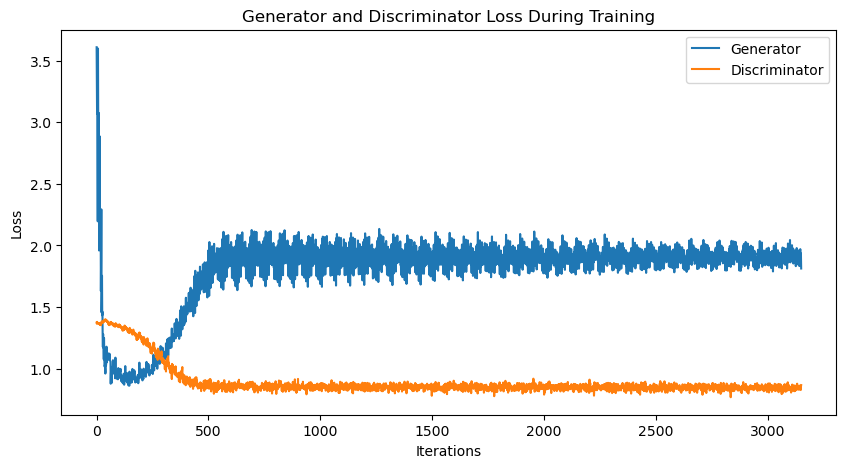

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(train_losses['Generator'],label="Generator")
plt.plot(train_losses['Discriminator'],label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

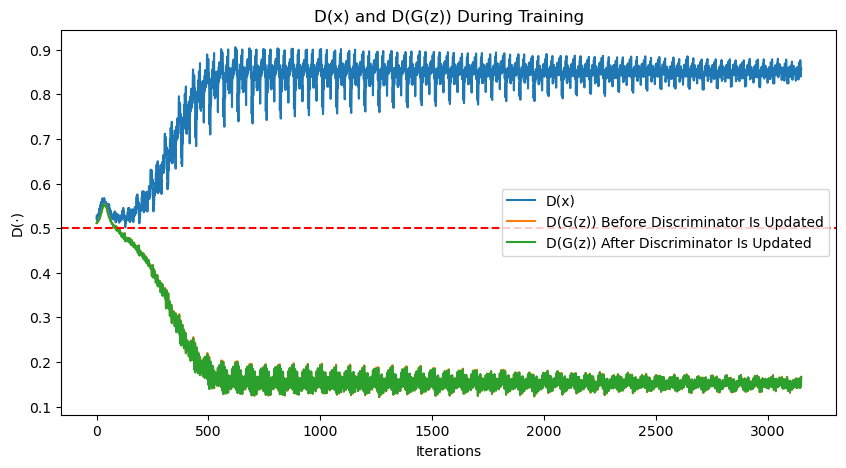

In [14]:
plt.figure(figsize=(10,5))
plt.title("D(x) and D(G(z)) During Training")
plt.plot(train_losses['Dx'],label="D(x)")
plt.plot(train_losses['D_G_z1'],label="D(G(z)) Before Discriminator Is Updated")
plt.plot(train_losses['D_G_z2'],label="D(G(z)) After Discriminator Is Updated")
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xlabel("Iterations")
plt.ylabel("D(·)") 
# Want the discriminator to get to a point where it guesses btw real and fake (0.5)
plt.legend()
plt.show()

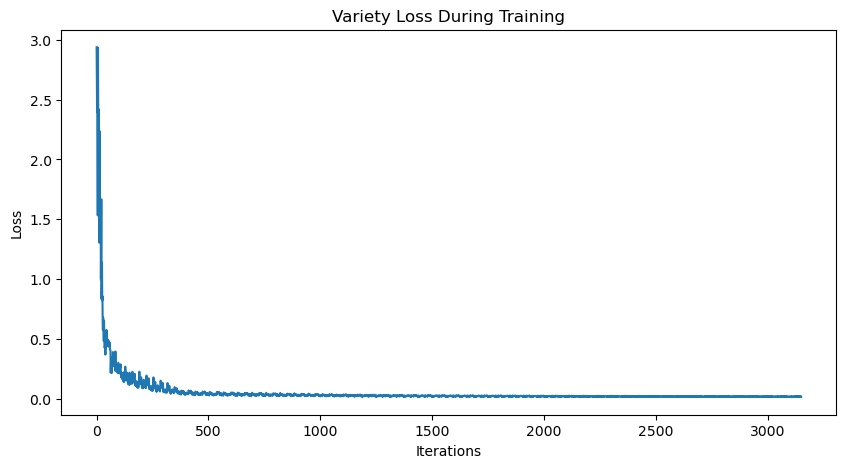

In [15]:
plt.figure(figsize=(10,5))
plt.title("Variety Loss During Training")
plt.plot(train_losses['Variety'])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

## Testing

In [16]:
test_batches = dataLoader(test_dataset, window=OBS_LENGTH, horizon=PRED_LENGTH, batch_size=BATCH_SIZE)

Making Fresh Batches: 100%|██████████| 16/16 [00:01<00:00,  8.54it/s]


In [17]:
def test_gan(test_batches, generator, discriminator, criterion, device, batch_size, k=1):
    
    generator.eval()  
    discriminator.eval()  

    evaluation_metrics = {
        'Generator': [],
        'Discriminator': [],
        'Dx': [],
        'D_G_z1': [],
        'D_G_z2': [],
        'Variety': [],
    }

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for i, batch in enumerate(tqdm(test_batches, desc='Testing')):
            obs_seq_batch = batch[0]
            target_seq_batch = batch[1]

            obs_seq_batch = [obs_batch.to(device) for obs_batch in obs_seq_batch]
            target_seq_batch = [target_batch.to(device) for target_batch in target_seq_batch]

            # Generate predictions
            y_hat_seq_batch = generator(obs_seq_batch, None, None)

            # Evaluate the discriminator on real data
            output_real_batch, _ = discriminator(target_seq_batch, None)
            real_labels = torch.ones(min(batch_size, output_real_batch.shape[0]), device=device)

            # Ensure the dimensions of `output_real_batch` and `real_labels` match
            if output_real_batch.dim() == 1:
                output_real_batch = output_real_batch.unsqueeze(0)
            if real_labels.dim() == 1:
                real_labels = real_labels.unsqueeze(0)

            err_disc_real_batch = criterion(output_real_batch.squeeze(), real_labels.squeeze())
            D_x = output_real_batch.mean().item()

            # Evaluate the discriminator on fake data
            output_fake_batch, _ = discriminator(y_hat_seq_batch, None)
            fake_labels = torch.zeros(min(batch_size, output_fake_batch.shape[0]), device=device)

            # Ensure the dimensions of `output_fake_batch` and `fake_labels` match
            if output_fake_batch.dim() == 1:
                output_fake_batch = output_fake_batch.unsqueeze(0)
            if fake_labels.dim() == 1:
                fake_labels = fake_labels.unsqueeze(0)

            err_disc_fake_batch = criterion(output_fake_batch.squeeze(), fake_labels.squeeze())
            D_G_z1 = output_fake_batch.mean().item()  # Before any updates
            err_disc = err_disc_fake_batch + err_disc_real_batch

            # Calculate variety loss
            k_L2_Losses = []
            for _ in range(k):
                y_hat_seq_k_batch = generator(obs_seq_batch, None, None)
                curr_L2_loss = sum(
                    [F.mse_loss(y_hat_seq_k_batch[i].x, target_seq_batch[i].x) for i in range(len(y_hat_seq_k_batch))]
                )
                k_L2_Losses.append(curr_L2_loss)
            min_L2_loss = min(k_L2_Losses)

            # Calculate generator loss based on the discriminator's output
            output = criterion(output_fake_batch.squeeze(), real_labels.squeeze())
            D_G_z2 = output_fake_batch.mean().item()  # After D is evaluated
            err_gen = min_L2_loss + output

            # Store evaluation metrics
            evaluation_metrics['Generator'].append(err_gen.item())
            evaluation_metrics['Discriminator'].append(err_disc.item())
            evaluation_metrics['Dx'].append(D_x)
            evaluation_metrics['D_G_z1'].append(D_G_z1)
            evaluation_metrics['D_G_z2'].append(D_G_z2)
            evaluation_metrics['Variety'].append(min_L2_loss.item())

            if i % 20 == 0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f | %.4f \tLoss_variety: %.4f'
                      % (i, len(test_batches), err_disc.item(), err_gen.item(), D_x, D_G_z1, D_G_z2, min_L2_loss.item()))

    return evaluation_metrics


In [18]:
test_losses = test_gan(test_batches=test_batches,
                  generator=generator,
                  discriminator=discriminator,
                  criterion=criterion,
                  device=device,
                  batch_size=BATCH_SIZE,
                  k=K,
                 )
with open("test_losses.json", "w") as outfile: 
    json.dump(test_losses, outfile)

Testing:   6%|▋         | 1/16 [00:01<00:28,  1.90s/it]

[0/16]	Loss_D: 0.3006	Loss_G: 2.0012	D(x): 0.8578	D(G(z)): 0.1369 | 0.1369 	Loss_variety: 0.0119


Testing: 100%|██████████| 16/16 [00:30<00:00,  1.88s/it]


## Visual Of Test Performance

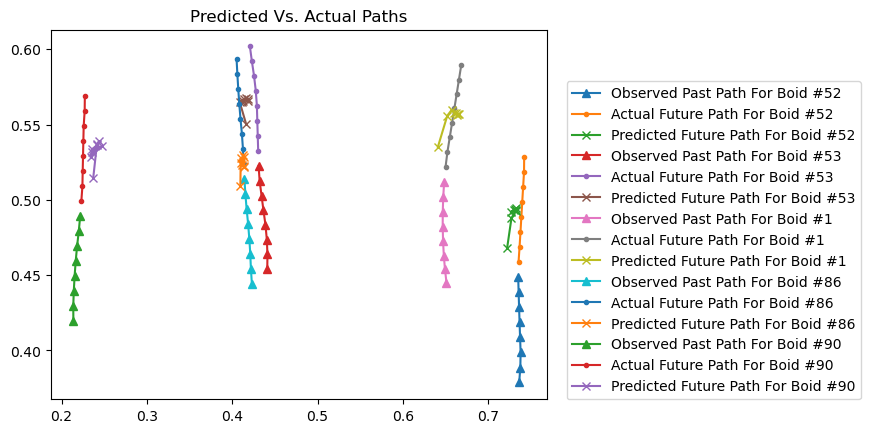

In [35]:
import random
single_batch = test_batches[random.randint(0, len(test_batches)-1)]

generator.eval()  
with torch.no_grad():
    obs_seq_batch = single_batch[0]
    target_seq_batch = single_batch[1]

    obs_seq_batch = [obs_batch.to(device) for obs_batch in obs_seq_batch]
    target_seq_batch = [target_batch.to(device) for target_batch in target_seq_batch]

    y_hat_seq_batch = generator(obs_seq_batch, None, None)

    obs_seq_batch = [obs_batch.to('cpu') for obs_batch in obs_seq_batch]
    target_seq_batch = [target_batch.to('cpu') for target_batch in target_seq_batch]
    y_hat_seq_batch = [y_hat_batch.to('cpu') for y_hat_batch in y_hat_seq_batch]
    
    y_hat_seq_xy_batch = [torch.reshape(y_hat_batch.x[:, 0:2], (-1, NUM_BOIDS, 2)) for y_hat_batch in y_hat_seq_batch]
    target_seq_xy_batch = [torch.reshape(target_batch.x[:, 0:2], (-1, NUM_BOIDS, 2)) for target_batch in target_seq_batch]
    obs_seq_xy_batch = [torch.reshape(obs_batch.x[:, 0:2], (-1, NUM_BOIDS, 2)) for obs_batch in obs_seq_batch]

    
    # Pick a random sequence from the batch
    random_i = random.randint(0, y_hat_seq_xy_batch[0].shape[0]-1)
    random_y_hat_seq_xy = [y_hat_xy_batch[random_i] for y_hat_xy_batch in y_hat_seq_xy_batch]
    random_target_seq_xy = [target_xy_batch[random_i] for target_xy_batch in target_seq_xy_batch]
    random_obs_seq_xy = [obs_xy_batch[random_i] for obs_xy_batch in obs_seq_xy_batch]
    random_boids = [random.randint(0, NUM_BOIDS-1) for _ in range(5)]
    plt.title('Predicted Vs. Actual Paths')
    for boid_id in random_boids:
        plt.plot([random_obs_seq_xy[i][boid_id][0] for i in range(len(random_obs_seq_xy))], [random_obs_seq_xy[i][boid_id][1] for i in range(len(random_obs_seq_xy))], marker='^', label=f'Observed Past Path For Boid #{boid_id}')
        plt.plot([random_target_seq_xy[i][boid_id][0] for i in range(len(random_target_seq_xy))], [random_target_seq_xy[i][boid_id][1] for i in range(len(random_target_seq_xy))], marker='.', label=f'Actual Future Path For Boid #{boid_id}')
        plt.plot([random_y_hat_seq_xy[i][boid_id][0] for i in range(len(random_y_hat_seq_xy))], [random_y_hat_seq_xy[i][boid_id][1] for i in range(len(random_y_hat_seq_xy))], marker='x', label=f'Predicted Future Path For Boid #{boid_id}')

    plt.legend(loc=(1.04, 0))
    plt.show()